In [93]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from geopy.distance import distance
import xgboost 

In [94]:
class ProjectKNN:
    data = None
    data_train = None
    data_test = None
    model = None
    optimizer = None
    loss_function = None
    model_loss = 10000
    early_stop = 0

    def __init__(self, data_path='LocTreino_Equipe_3.csv', log_dir='log_mlp/'):
        self.data = pd.read_csv(data_path)
        self.preproccess_data()
        self.split_data()
        self.declare_model()

    def preproccess_data(self):
        self.data = self.data.drop_duplicates()
        self.data = self.data.dropna()

    def split_data(self):
        self.X = self.data[[
            x for x in self.data.columns if x not in ('lat', 'lon')]].values
        self.y = self.data[[
            x for x in self.data.columns if x in ('lat', 'lon')]].values

        self.data_train = self.data_test = self.data
        self.data_train = self.data_train[:int(0.9 * len(self.data_train))]
        self.data_test = self.data_test[int(0.9 * len(self.data_test)):]

    def declare_model(self):
        # params = {'n_neighbors': [1, 3, 5, 8, 13],
        #           'metric': ['euclidian', 'manhattan'],
        #           'weights': ['uniform', 'distance'],
        #           'leaf_size': [30, 33, 55, 88]
        #           }
        # knn = KNeighborsRegressor()
        # self.model = GridSearchCV(knn, params,
        #                           verbose=1, cv=3, n_jobs=-1)
        self.model = KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                         metric='manhattan',
                                         metric_params=None,
                                         n_jobs=-1, n_neighbors=1,
                                         p=2, weights='distance')

    def train(self):
        batch = self.data_train
        x_batch = batch[[
            x for x in batch.columns if x not in ('lat', 'lon')]].values
        y_batch = batch[[
            x for x in batch.columns if x in ('lat', 'lon')]].values

        self.model.fit(x_batch, y_batch)
        # self.model = knn.model.best_estimator_
        # print(self.model)

    def test(self):
        x_batch = self.data_test[[
            x for x in self.data_test.columns if x not in ('lat', 'lon')]].values
        y_batch = self.data_test[[
            x for x in self.data_test.columns if x in ('lat', 'lon')]].values

        out = self.model.predict(x_batch)
        return out, y_batch

    def result_analisys(self, out, y_batch):
        fig, ax = plt.subplots()
        ax.plot([x[0] for x in y_batch], [x[1]
                                          for x in y_batch], 'o', label='Real')
        ax.plot([x[0] for x in out], [x[1] for x in out], 'x', label='KNN')
        ax.legend()
        ax.set_title('Comparação')
        fig.savefig('knn_map.png')

        dists = []
        for i in range(len(out)):
            dist = distance(y_batch[i], out[i]).km*1000
            dists.append(dist)
        
        fig, ax = plt.subplots()
        ax.boxplot(dists)
        ax.set_title('BoxPlot Dists')
        fig.savefig('knn_boxplot_dists.png')

        fig, ax = plt.subplots()
        ax.hist(dists)
        ax.set_title('Histogram Dists')
        fig.savefig('knn_hist_dists.png')


        print(f'Erro Médio: {np.mean(dists)}\nErro Mínimo: {min(dists)}\n\
Erro Máximo: {max(dists)}\nDesvio Padrão: {np.std(dists)}')

In [95]:
class ProjectXGBOOST:
    data = None
    data_train = None
    data_test = None
    model = None
    optimizer = None
    loss_function = None
    model_loss = 10000
    early_stop = 0

    def __init__(self, data_path='LocTreino_Equipe_3.csv', log_dir='log_mlp/'):
        self.data = pd.read_csv(data_path)
        self.preproccess_data()
        self.split_data()
        self.declare_model()

    def preproccess_data(self):
        self.data = self.data.drop_duplicates()
        self.data = self.data.dropna()

    def split_data(self):
        self.X = self.data[[
            x for x in self.data.columns if x not in ('lat', 'lon')]].values
        self.y = self.data[[
            x for x in self.data.columns if x in ('lat', 'lon')]].values

        self.data_train = self.data_test = self.data
        self.data_train = self.data_train[:int(0.9 * len(self.data_train))]
        self.data_test = self.data_test[int(0.9 * len(self.data_test)):]

    def declare_model(self):
        self.model_lat = xgboost.XGBRegressor(gamma=0,                 
                 learning_rate=0.01,
                 max_depth=30,
                 n_estimators=100000,                                                      
                 objective='reg:squarederror',
                 n_jobs=-1)
        self.model_lon = xgboost.XGBRegressor(gamma=0,                 
                 learning_rate=0.01,
                 max_depth=30,
                 n_estimators=100000,                                                      
                 objective='reg:squarederror',
                 n_jobs=-1)

    def train(self):
        batch = self.data_train
        x_batch = batch[[
            x for x in batch.columns if x not in ('lat', 'lon')]].values
        y_batch = batch[[
            x for x in batch.columns if x in ('lat', 'lon')]].values

        self.model_lat.fit(x_batch, batch.lat)
        self.model_lon.fit(x_batch, batch.lon)
        

    def test(self):
        x_batch = self.data_test[[
            x for x in self.data_test.columns if x not in ('lat', 'lon')]].values
        y_batch = self.data_test[[
            x for x in self.data_test.columns if x in ('lat', 'lon')]].values

        out_lat = self.model_lat.predict(x_batch)
        out_lon = self.model_lon.predict(x_batch)
        out = list(zip(out_lat, out_lon))
        return out, y_batch
    

    def result_analisys(self, out, y_batch):
        fig, ax = plt.subplots()
        ax.plot([x[0] for x in y_batch], [x[1]
                                          for x in y_batch], 'o', label='Real')
        ax.plot([x[0] for x in out], [x[1] for x in out], 'x', label='XGBoost')
        ax.legend()
        ax.set_title('Comparação')
        fig.savefig('xgboost_map.png')

        dists = []
        for i in range(len(out)):
            dist = distance(y_batch[i], out[i]).km*1000
            dists.append(dist)
        
        fig, ax = plt.subplots()
        ax.boxplot(dists)
        ax.set_title('BoxPlot Dists')
        fig.savefig('xgboost_boxplot_dists.png')

        fig, ax = plt.subplots()
        ax.hist(dists)
        ax.set_title('Histogram Dists')
        fig.savefig('xgboost_hist_dists.png')


        print(f'Erro Médio: {np.mean(dists)}\nErro Mínimo: {min(dists)}\n\
Erro Máximo: {max(dists)}\nDesvio Padrão: {np.std(dists)}')

Erro Médio: 32.817617276628965
Erro Mínimo: 1.1022833462738364
Erro Máximo: 720.9093171316518
Desvio Padrão: 83.80250421153384


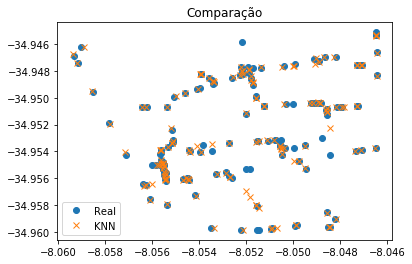

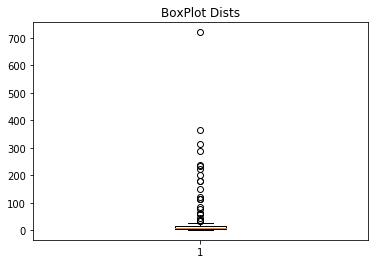

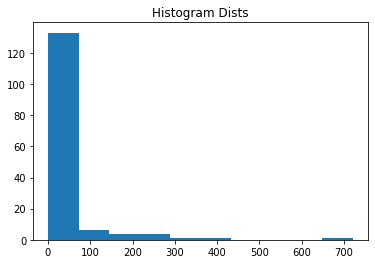

In [96]:
knn = ProjectKNN()
knn.train()
result = knn.test()
knn.result_analisys(*result)

/home/inteligonca/.cache/pypoetry/virtualenvs/jurimetria-py3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/inteligonca/.cache/pypoetry/virtualenvs/jurimetria-py3.7/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Erro Médio: 38.39626347065202
Erro Mínimo: 2.1368802651707135
Erro Máximo: 142.99424812783724
Desvio Padrão: 30.480936769205275


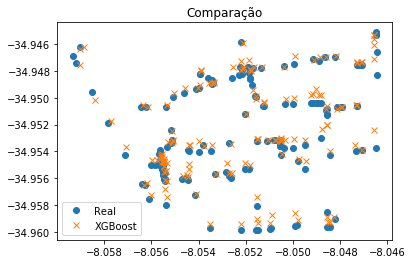

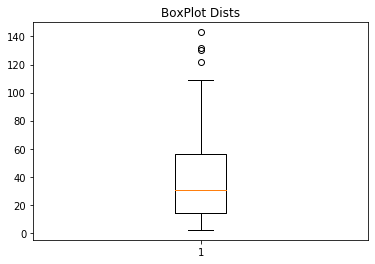

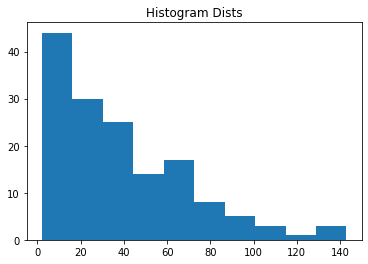

In [97]:
xgmodel = ProjectXGBOOST()
xgmodel.train()
result = xgmodel.test()
xgmodel.result_analisys(*result)